<div style="text-align: center;">
    <span style="color: red; font-size: 70px;"> Monte-Carlo paths</span>
</div>

In [13]:
import math
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import ScalarMappable

from scipy.stats import norm

Un sistema quantistico è governato dalla matrice densità, che è definita per mezzo delle funzioni d'onda e degli autostati di energia. Il calcolo analitico della matrice densità non è scontato, in quanto non sempre conosciamo esplicitamente le soluzioni dell'equazione di Schrodinger.

<center>

#### Tecnica di convoluzione
</center>

La matrice densità presenta un'espressione semplice solo ad alte temperature: la casistica a bassa temperatura può essere recuperata dal limite $T \gg 1$ mediante una tecnica di convoluzione, che applicata in modo iterativo pone le basi per l'integrale sui cammini di Feynman.

$$
\int dx' \rho\left(x,\,x',\,\beta_1\right) \rho\left(x',\,x'',\,\beta_2\right)\,=\,\rho\left(x,\,x'',\,\beta_1\,+\,\beta_2\right)
$$

<center>

#### Feynman path integral
</center>

La convoluzione di matrici densità ad alte temperature non può essere sempre valutata in modo analitico, ma è possibile ottenerne una stima per mezzo di tecniche Monte-Carlo. Procediamo in modo iterativo esplicitando tutte le integrazioni contemporaneamente, in modo tale che al passo k-esimo il numero di matrici densità considerate sia $2^k$:

$$
\rho\left(x_0,\,x_N,\,\beta\right)\,=\,\int dx_1 \dots dx_{N-1}\,\rho\left(x_0,\,x_1,\,\beta/N\right)\dots\rho\left(x_{N-1},\,x_N,\,\beta/N\right)
$$

La funzione di partizione, che è la traccia della matrice densità, viene valutata andando ad introdure un'ulteriore integrazione, in modo tale che:

$$
Z\,=\,\int dx_0\,\rho\left(x_0,\,x_0,\,\beta\right)
$$

La configurazione $\left\{x_0,\,\dots,\,x_N\right\}$ è detta cammino, della qual possiamo interpretare la variabile $x_k$ come la posizione al tempo d'evoluzione immaginario $k\beta/N$. Nel momento in cui il numero di completezze introdotte in precedenza è elevato, è possibile lavorare con la decomposizione di Trotter, trascurando il fatto che $\left[H,\,V\right]\,\neq\, 0$, ottenendo che:

$$
\exp{\left[-\frac{\beta}{N}\left(\hat{T}\,+\,\hat{V}\right)\right]}\,=\,\exp{\left(-\frac{\beta}{2N}\hat{V}\right)}\exp{\left(-\frac{\beta}{N}\hat{T}\right)}\exp{\left(-\frac{\beta}{2N}\hat{V}\right)}
$$

<div style="text-align: center;">
    <span style="color: blue; font-size: 40px;"> Naive path sampling</span>
</div>

L'integrale sui cammini di Feynman descrive una singola paticella in termini di cammini $\left\{x_0,\,\dots,\,x_N\right\}$ con pesi legati alle singole matrici densità ad alta temperatura. La funzione di partizione 

$$
Z\,=\,\int dx_0 \dots dx_{N-1}\,\rho\left(x_0,\,x_1,\,\beta/N\right)\dots\rho\left(x_{N-1},\,x_0,\,\beta/N\right)
$$

può essere interpretata come una somma su tutti i cammini possibili, pesati sulle loro probabilità. Per campionare un certo cammino si sceglie casualmente un indice $k$ della catena e si valuta la mossa

$$
x_k\,\longrightarrow x_k\,+\,\delta_k
$$

con l'algoritmo di Metropolis. Il rapporto fra i pesi della nuova e della vecchia configurazione coinvolge solo i due segmenti che legano la posizione k-esima a quella precedente e a quella successiva. Solitamente un algoritmo del genere, detto di _local path sampling_ è molto lento e mostra delle problematiche a scorrelarsi dalla configurazione iniziale: i passi lunghi non vengono accettati, in quanto il peso statistico ad esso associati è praticamente nullo.

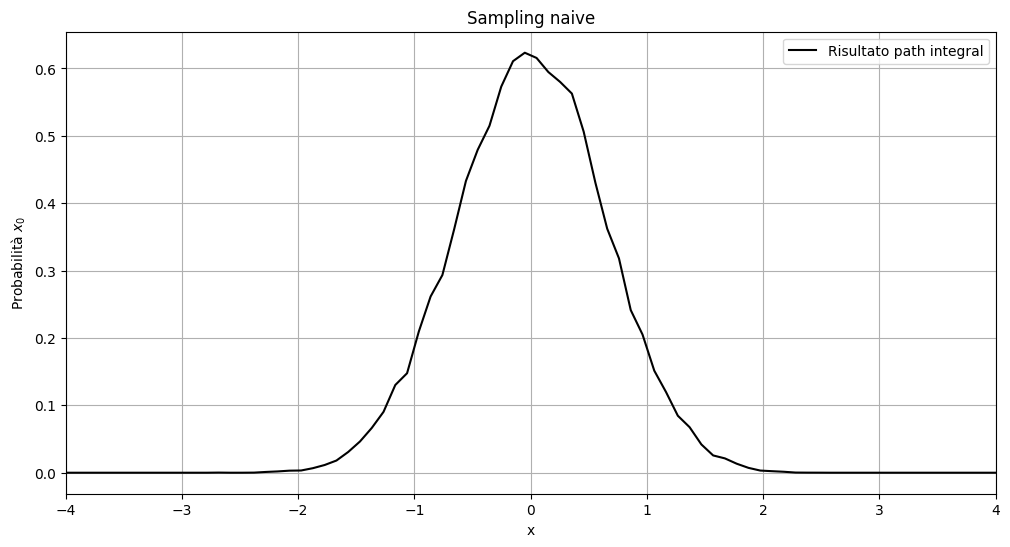

In [14]:
plt.figure(figsize=(12,6))

x = np.linspace(-4, 4, 80)
appo = np.loadtxt('naivePath/histo.dat')

plt.plot(x,appo/sum((x[1]-x[0])*appo), color = 'black', label = 'Risultato path integral')

plt.xlabel("x")
plt.xlim((-4,4))
plt.ylabel(r"Probabilità $x_0$")
plt.title("Sampling naive")

plt.grid(True)
plt.legend()
plt.show()

<div style="text-align: center;">
    <span style="color: blue; font-size: 40px;"> Direct sampling</span>
</div>

Per superare le limitazioni dell'algoritmo di campionamento dei cammini proposto in precedenza è necessario affrontare la problematica principale, ossia che le mosse sono estratte con probabilità uniforme in un intervallo di ampiezza delta, in modo che
$$
x_{new}\,\in\,\left(x_k\,-\,\delta,\,x_k\,+\,\delta\right).
$$
Abbiamo osservato in precedenza come la propabilità di accettare una mossa fra le posizioni $x'$ ed $x''$ avesse un andamento gaussiano nella parte cinetica, ossia caratterizzata da
$$
\pi^{free}\left(x_k\,|\,x',\,x''\right)\,\propto \exp{\left[-\frac{\left(x_k\,-\,\left<x_k\right>\right)^2}{2\sigma^2}\right]}
$$
dove il valore medio della variabile $x_k$ si ottiene come
$$
\left<x_k\right>\,=\,\frac{x'\,+\,x''}{2}
$$
e la varianza è invece data da
$$
\sigma^2\,=\,\frac{\Delta_\tau}{2}.
$$
Nelle scritture precedenti si è supposto che gli intervalli temporali fossero uguali per i due step presi in considerazione. Ciò che possiamo pensare di fare per aumentare il tasso di accettazione è di estrarre i valori $x_k$ da una distribuzione gaussiana, in modo tale da essere sicuri che le mosse non vengano rifiutate. In particolare consideriamo:

$$
\begin{cases}
x'\,=\,x_{k-1}\\
x''\,=\,x_{k+1}\\
\Delta_\tau\,=\,\beta/N
\end{cases}
$$

E' possibile generalizzare questa metodologia di fare sampling per campionare l'intero cammino, lavorando inzialmente per determinare $x_1$, passando poi ad $x_2$ e così via.


Anche nel caso di una particella in un potenziale armonico esterno è possibile lavorare estraendo valori da una distribuzione gaussiana, il cui valor medio e varianza saranno differenti rispetto al caso di propagazione libera (per effetti quindi di sola natura cinetica). Abbiamo in particolare che

$$
\begin{cases}
\left<x_k\right>\,=\,\Phi_2/\Phi_1 \\
\sigma\,=\,\Phi_1^{-1/2}
\end{cases}
$$

dove $\Phi_1$ e $\Phi_2$ possono essere ricavati come:

$$
\Phi_1\,=\,\coth{\left(\Delta_\tau'\right)}\,+\,\coth{\left(\Delta_\tau''\right)}
$$
$$
\Phi_2\,=\,\frac{x'}{\sinh{\left(\Delta_\tau'\right)}}\,+\,\frac{x''}{\sinh{\left(\Delta_\tau''\right)}}
$$



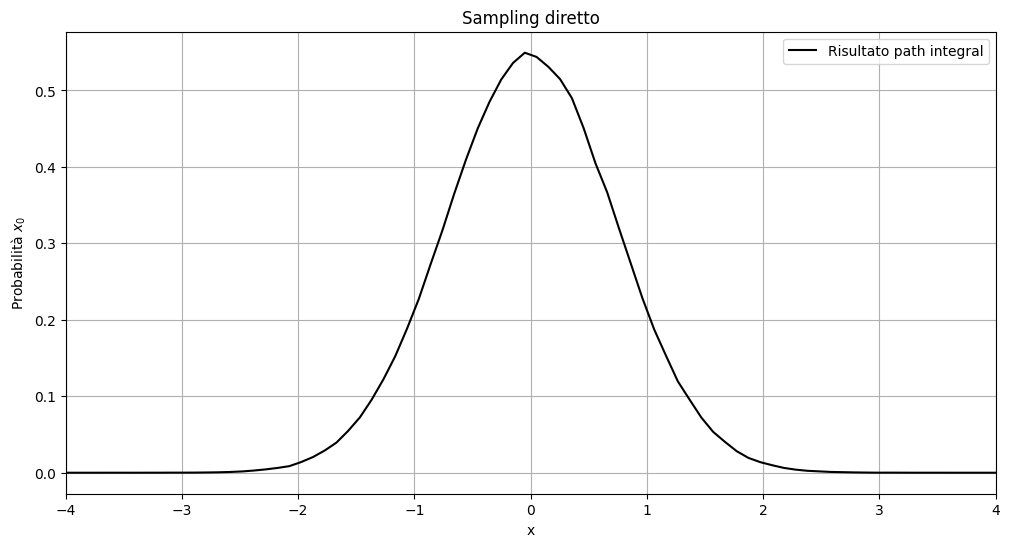

In [15]:
plt.figure(figsize=(12,6))

x = np.linspace(-4, 4, 80)
appo1 = np.loadtxt('directPath/histo.dat')

plt.plot(x,appo1/sum((x[1]-x[0])*appo1), color = 'black', label = 'Risultato path integral')

plt.xlabel("x")
plt.xlim((-4,4))
plt.ylabel(r"Probabilità $x_0$")
plt.title("Sampling diretto")

plt.grid(True)
plt.legend()
plt.show()

<div style="text-align: center;">
    <span style="color: blue; font-size: 40px;"> Confronto fra metodologie</span>
</div>

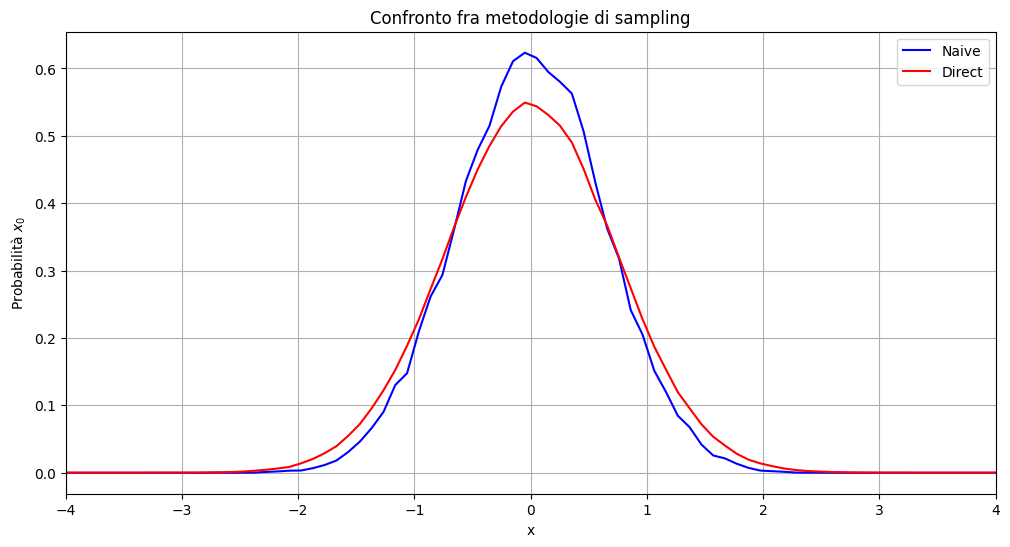

In [16]:
plt.figure(figsize=(12,6))

x = np.linspace(-4, 4, 80)
appo = np.loadtxt('naivePath/histo.dat')
appo1 = np.loadtxt('directPath/histo.dat')

plt.plot(x,appo/sum((x[1]-x[0])*appo), color = 'blue', label = 'Naive')
plt.plot(x,appo1/sum((x[1]-x[0])*appo1), color = 'red', label = 'Direct')

plt.xlabel("x")
plt.xlim((-4,4))
plt.ylabel(r"Probabilità $x_0$")
plt.title("Confronto fra metodologie di sampling")

plt.grid(True)
plt.legend()
plt.show()